In [1]:
from audioFunctions import *
from binaryFunctions import *
from qam import *
from sequenceGenerators import *
from receiver import *
from error_coding import *
from to_import import *

In [2]:
CE_binary = binaryTextFileToBinary('Data_Files/random_bits.txt')
#binary = fileToBinary('Data_Files/kokoro_text.txt')
binary = binaryTextFileToBinary('Data_Files/kokoro_bin.txt')

CE_symbols = qpsk(CE_binary)
coded_binary = Hamming74(binary)

In [3]:
# Set the parameters for transmission
CP = 704 
N = 4096
guard = 5
CE_repeat = 20

frame_data_length = 180

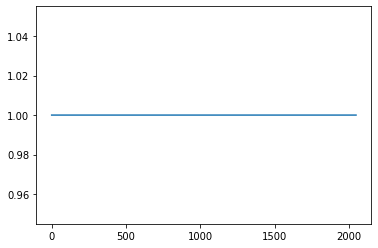

In [4]:
# Make your instructions
instruction = []
for i in range(2047):
    if i <150000:
        instruction.append(1)
    else: 
        instruction.append(0)
plot_y(instruction)

In [5]:
symbols = varyingModulation_std(coded_binary,instruction, N, CE_binary, 360)
#symbols_verify = qpsk(coded_binary)

bitcount 4094
additional  3396
data length  5580820
new data len  5584216
symbol number 1 is done.
symbol number 2 is done.
symbol number 3 is done.
symbol number 4 is done.
symbol number 5 is done.
symbol number 6 is done.
symbol number 7 is done.
symbol number 8 is done.
symbol number 9 is done.
symbol number 10 is done.
symbol number 11 is done.
symbol number 12 is done.
symbol number 13 is done.
symbol number 14 is done.
symbol number 15 is done.
symbol number 16 is done.
symbol number 17 is done.
symbol number 18 is done.
symbol number 19 is done.
symbol number 20 is done.
symbol number 21 is done.
symbol number 22 is done.
symbol number 23 is done.
symbol number 24 is done.
symbol number 25 is done.
symbol number 26 is done.
symbol number 27 is done.
symbol number 28 is done.
symbol number 29 is done.
symbol number 30 is done.
symbol number 31 is done.
symbol number 32 is done.
symbol number 33 is done.
symbol number 34 is done.
symbol number 35 is done.
symbol number 36 is done.

symbol number 306 is done.
symbol number 307 is done.
symbol number 308 is done.
symbol number 309 is done.
symbol number 310 is done.
symbol number 311 is done.
symbol number 312 is done.
symbol number 313 is done.
symbol number 314 is done.
symbol number 315 is done.
symbol number 316 is done.
symbol number 317 is done.
symbol number 318 is done.
symbol number 319 is done.
symbol number 320 is done.
symbol number 321 is done.
symbol number 322 is done.
symbol number 323 is done.
symbol number 324 is done.
symbol number 325 is done.
symbol number 326 is done.
symbol number 327 is done.
symbol number 328 is done.
symbol number 329 is done.
symbol number 330 is done.
symbol number 331 is done.
symbol number 332 is done.
symbol number 333 is done.
symbol number 334 is done.
symbol number 335 is done.
symbol number 336 is done.
symbol number 337 is done.
symbol number 338 is done.
symbol number 339 is done.
symbol number 340 is done.
symbol number 341 is done.
symbol number 342 is done.
s

In [6]:
# So far this works the best at estimating the location... 
chirp_signal = Chirp(500,20500,1, volume = 100)

In [7]:
print(len(symbols))

736920


In [8]:
# For channel esimation (CE)

# prepare channel esitimation data to be transmitted 
CE_Time, CE_Freq = ofdmSymbols(CE_symbols, CP, N)
print(CE_Time.shape)


## THIS IS WHERE I NEED TO INCLUDE KISEKI's FUNCTION

Payload_Time, Payload_Freq = ofdmSymbols(symbols, CP, N)



extra = frame_data_length - len(Payload_Time)%frame_data_length
print(len(Payload_Time), extra)
for i in range(extra):
    Payload_Time = np.concatenate((Payload_Time, [CE_Time[1]]))
    
num_of_frames = int(len(Payload_Time)/frame_data_length)

print(num_of_frames)

(3, 4800)
360 180
3


In [9]:
# Prepare what to transmit

# Channel estimation at the beginning
CE_transmit = repeat_signal(CE_Time[0], CE_repeat)
known_freq = CE_Freq[0]

# Payload mixed with CE symbols distributed between them
Payload = prepare_payload_std(Payload_Time, CE_transmit, chirp_signal, num_of_frames, frame_data_length)

num_of_frames = 2
Payload = Payload[:num_of_frames]

In [10]:
x = save_transmit( tuple(Payload) , playOutput=False)
print("Transmit signal is ", round(len(x)/fs, 2), " seconds")

Transmit signal is  46.0  seconds


In [11]:
y = audioDataFromFile('Wav_Files/long_recording.wav')


data_index_length = frame_data_length * (N+CP)
CE_index_length = CE_repeat * (N+CP)

freq_data = []
# big loop to find out everything
for i in range(num_of_frames):
    # obtain only the time series we are interested in 
    y_data = removeChirpAndPause_std(y, chirp_signal, 400000, plot = False, rng = 100)
    
    # Slice the data to retrieve the CE
    CE_samples, CE_freq, remaining = sliceData(y_data, CP-guard, N, CP, CE_repeat)
    CE_samples_end, CE_freq_end, remaining_end \
                    = sliceData(y_data[data_index_length + CE_index_length:], CP-guard, N, CP, CE_repeat)
    
    
    # Examine any phase shift 
    impulse_front, TF_front = getTF_FreqAverage(CE_freq, known_freq, N, CE_repeat)
    impulse_end, TF_end = getTF_FreqAverage(CE_freq_end, known_freq, N, CE_repeat)


    start_index = 0
    end_index = start_index + 2048
    TF_front_relevant =TF_front[start_index:end_index]
    TF_end_relevant = TF_end[start_index:end_index]
    
    '''
    for i in range(len(TF_end_roll)):
        TF_end_roll[i] = TF_end_roll[i]#* cmath.rect(1, (2*math.pi/4096)* (i*3.33 + 8.61))
        
    '''    
    angle_front = np.unwrap(np.angle(TF_front_relevant))
    angle_end = np.unwrap(np.angle(TF_end_relevant))

    difference = []
    for p, val in enumerate(angle_end):
        difference.append(round(val - angle_front[p], 3))
    '''    
    print(difference[:15])
    print(difference[-15:])

        
    diff = np.transpose(np.stack((difference, np.ones(np.array(difference).shape))))
    x = np.linspace(start_index, end_index, end_index- start_index)
    param = scipy.linalg.lstsq(diff, x)

    plot_y(difference[:1024], f = i+100, title = i)
    plot_y(angle_front, f = i, title = i)
    plot_y(angle_end, f= i)
    
    plt.figure(1000)
    plt.yscale("log")
    plt.plot(abs(np.array(TF_front))[:2048])
    plt.plot(abs(np.array(TF_end))[:2048])
    plot_y(abs(np.array(TF_front))[:2048], f=2)
    
    '''
    stable_phase_start = 200
    stable_phase_length = 200
    p = np.linspace(stable_phase_start,   stable_phase_start + stable_phase_length,   stable_phase_length)
    q = difference[stable_phase_start:   stable_phase_start + stable_phase_length  ]
    
    param = np.polyfit(p,q,1)
    print("param ", param)
    grad = param[0]
    
    if i == 0:
        freq_data = sliceDataContent_std(TF_front, TF_end, remaining, CP-guard, N, CP, frame_data_length, grad, CE_repeat)
    else:
        freq_data = np.concatenate((freq_data, \
                        sliceDataContent_std(TF_front, TF_end, remaining, CP-guard, N, CP, frame_data_length, grad, CE_repeat)))
    
    y = remaining_end

param  [-0.00742644  6.27147075]
param  [-0.00766976 -0.00990209]


In [12]:
print(freq_data.shape)

(360, 2047)


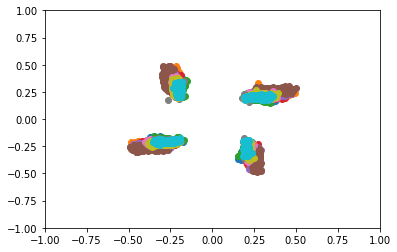

In [13]:
for i in range(10):
    plot_res = np.array(freq_data[i+150])[200:1500]
    plt.scatter(plot_res.real, plot_res.imag)
    window = 1
    plt.xlim(-1*window,window)
    plt.ylim(-1*window, window)

In [15]:
print(len(freq_data))
data1 = np.concatenate(tuple(freq_data))#[4*20:4*40]
predict = iHamming74(iqpsk(data1))
predict2 = iHamming74(iqpsk(data1))

#actual = iqpsk()
correct = 0
for i, val in enumerate(predict):
    if val == binary[i]:
        correct += 1

print(correct/len(predict))


360
0.9169773638315254


In [20]:
data1 = np.concatenate(tuple(freq_data[:100]))#[4*20:4*40]
predict = iHamming74(iqpsk(data1))
str_to_bytearray(predict).decode('utf-8', 'replace')

'0art 1: Sensei and I    I ALWAYS called him "Sensei." [note1] I shall therefore refer to him simply as "Sensei," and not by his real name. It is not because I consider it more discreet, but it is because I find it more natural that I do so. When�6`<��G\x10�����\x17f�Y�ˇ��\x18od��O��\x19���@Zʚ�h\x14��8�U�)nd that I think of him as "Sensei" still. And with pen in hand, I cannot bring myself to write of him in any other way.  It was at Kamakura, during the summer holidays, that I first met Sensei. I was then a very young student. I went there at vj�\x00\'�[�3�Bs88��Za\x08h��a�\x13�\x00���T��7�#A�ǪO�L�y\x12�.\nto Kamakura to swim. We were not together for long. It had taken me a few days to get together enough money to cover the necessary expenses, and it was only three days after my arrival that my friend received a telegram from home demanding his r`6}q�\x12�\x0c�\x0f\x02>!�A�=7\x12��[�np�Z\tZ�B�\\c]2�Y�ˍ���_�ill. My friend, however, did not believe this. For some time his parents had b

In [192]:
instruction = []
for i in range(2047):
    if i <200:
        instruction.append(1)
    else: 
        instruction.append(2)
    
print(len(instruction), type(instruction))

2047 <class 'list'>


In [193]:
test_bin = CE_binary
len(test_bin)
len(coded_binary)/len(test_bin)

465.0683333333333

In [194]:
blah = varyingModulation_test(test_bin,instruction, N, CE_binary)
print(blah)
print(len(blah), len(CE_symbols))

bitcount 7788
additional  3576
data length  12000
new data len  15576
[-0.70710678-0.70710678j  0.70710678-0.70710678j  0.70710678+0.70710678j
 ...  0.25      -0.75j        0.75      -0.25j
  0.75      +0.25j      ]
4094 6000
